<a href="https://colab.research.google.com/github/KamilShape/emotion_recognition/blob/main/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Introduction**

In [24]:
#Libraries
import os
import cv2
from google.colab.patches import cv2_imshow
import shutil
#----------------visualisation---------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#----------------keras-----------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
#---------------PIL--------------------------
from PIL import Image

In [3]:
data_path = 'drive/MyDrive/faces/data'

In [4]:
people = ['smiling-person', 'anger-person', 'disgust-person', 'fear-person', 'surprise-person' ]

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
photos_number = []
for person in people:
  photos_number.append(len(os.listdir(f'{data_path}/{person}')))

In [7]:
photos_number

[0, 0, 0, 0, 0]

### 1.1 Data visualisation

In [6]:
# fig, ax = plt.subplots(figsize = (8,6))
# ax.bar(people, photos_number, color='wheat', width=0.6)
# ax.set_title('PHOTOS')
# ax.set_ylabel('Amount')

# for i in range(0, len(people)):
#   ax.text(people[i], photos_number[i] - 20, horizontalalignment='center', s=photos_number[i] )

*Dataset is quite balanced.*

# **2. Train and test set**

In [8]:
train_path = 'drive/MyDrive/faces/train'

In [9]:
test_path = 'drive/MyDrive/faces/test'

In [10]:
def create_set(faces, path, new_path, set_size):
  for face in faces:
    files_folder = os.listdir(f'{path}/{face}')
    for n in range(0, round(len(files_folder)*set_size)):
      files_folder = os.listdir(f'{path}/{face}')
      photo_number = np.random.randint(len(files_folder))
      print(photo_number)
      os.makedirs(f'{new_path}/{face}', exist_ok=True)
      os.replace(f'{path}/{face}/{files_folder[photo_number]}', f'{new_path}/{face}/{files_folder[photo_number]}')

In [ ]:
#creating train set
create_set(people, data_path, train_path, 0.8)

In [ ]:
#creating test set
create_set(people, data_path, test_path, 1)

# **3. Face detection**

In [11]:
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
def face_recognition(photo, array):
  image = cv2.imread(photo)
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  face = face_classifier.detectMultiScale(gray_image, 1.3, 4)
  if len(face) > 0:
   for i, (x, y, w, h) in enumerate(face):
      cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 255), 2)
      face = image[y:y + h, x:x + w]
      array.append(face)

In [12]:
smiling_faces_test = []
anger_faces_test = []
disgust_faces_test = []
fear_faces_test = []
surprise_faces_test = []

In [13]:
smiling_faces_train = []
anger_faces_train = []
disgust_faces_train = []
fear_faces_train = []
surprise_faces_train = []

In [14]:
def faces_array(array, photos, path):
  files_folder = os.listdir(f'{path}/{photos}')
  print(f'{path}/{photos}')
  for i in range(0, len(files_folder)):
    img_path = f'{path}/{photos}/{files_folder[i]}'
    print(img_path)
    face_recognition(img_path, array)

In [15]:
faces_array(smiling_faces_test, "smiling-person", train_path)
faces_array(anger_faces_test, "anger-person", train_path)
faces_array(disgust_faces_test, "disgust-person", train_path)
faces_array(fear_faces_test, "fear-person", train_path)
faces_array(surprise_faces_test, "surprise-person", train_path)

drive/MyDrive/faces/train/smiling-person
drive/MyDrive/faces/train/smiling-person/zbli%C5%BCenie-u%C5%9Bmiechni%C4%99tej-doros%C5%82ej-bizneswoman.jpg?s=612x612&w=0&k=20&c=o_57WTsILfxXQnzALXWwUrboS5RG2aYEJQ3VUgcYbu0=
drive/MyDrive/faces/train/smiling-person/portret-szcz%C4%99%C5%9Bliwego-dojrza%C5%82ego-m%C4%99%C5%BCczyzny-u%C5%9Bmiechni%C4%99tego.jpg?s=612x612&w=0&k=20&c=llGAb1tK493y7rjbMmaLasu7gQGkbpLTIhpUOM4VJuI=
drive/MyDrive/faces/train/smiling-person/portret-m%C5%82odej-doros%C5%82ej-azjatki-w-wenecji.jpg?s=612x612&w=0&k=20&c=KIXQ_uGvjWxqNNidUkBISWRS-9pvXdJAKs2oNj33Taw=
drive/MyDrive/faces/train/smiling-person/weso%C5%82a-m%C5%82oda-kobieta-%C5%9Bwi%C4%99tuje-i-ta%C5%84czy.jpg?s=612x612&w=0&k=20&c=6rTbAabwgKEidkXOCSTOirVBEIof3QGdZywKJWK4UXQ=
drive/MyDrive/faces/train/smiling-person/okulary-dziewczyna-w-kolorze-bia%C5%82ym.jpg?s=612x612&w=0&k=20&c=ZUMwXLoI_CoctCzI043wq8K4cJbO33xvaikGUZ3DBA0=
drive/MyDrive/faces/train/smiling-person/m%C5%82oda-pi%C4%99kna-kobieta-ubrana-w-zielon%C4

In [16]:
faces_array(smiling_faces_train, "smiling-person", test_path)
faces_array(anger_faces_train, "anger-person", test_path)
faces_array(disgust_faces_train, "disgust-person", test_path)
faces_array(fear_faces_train, "fear-person", test_path)
faces_array(surprise_faces_train, "surprise-person", test_path)

drive/MyDrive/faces/test/smiling-person
drive/MyDrive/faces/test/smiling-person/pewny-siebie-m%C5%82ody-m%C4%99%C5%BCczyzna-w-swobodnej-zielonej-koszuli-patrz%C4%85cy-z-dala-stoj%C4%85c-ze.jpg?s=612x612&w=0&k=20&c=qvotBSKmlWEpUBS0Lg7KXNfpY7M94XnQyzLpvlf2bPc=
drive/MyDrive/faces/test/smiling-person/rodzina-w-domu.jpg?s=612x612&w=0&k=20&c=QyxHO-AtTZLVt5i0nn2ywe7jspXVe5jWohA_y16-lGA=
drive/MyDrive/faces/test/smiling-person/weso%C5%82y-m%C5%82ody-sportowiec-na-%C5%9Bwie%C5%BCym-powietrzu-nad-rzek%C4%85.jpg?s=612x612&w=0&k=20&c=fu9621qgNcOuYkWBNvOysyeTBtYqEllM5NlYjaiDmq0=
drive/MyDrive/faces/test/smiling-person/dojrza%C5%82y-mieszany-cz%C5%82owiek-biznesu-rasy.jpg?s=612x612&w=0&k=20&c=GrghENJn2cnLe9h8LnG93vk0KxWoLBA-DjLPP2p_Afk=
drive/MyDrive/faces/test/smiling-person/zr%C3%B3%C5%BCnicowani-koledzy-z-biura-%C5%9Bmiej%C4%85-si%C4%99-razem-podczas-spotkania.jpg?s=612x612&w=0&k=20&c=o-sqSOHzzCQZu6tuZ8NWY7lgxrpg7iXIkafe4EgfMV0=
drive/MyDrive/faces/test/smiling-person/szcz%C4%99%C5%9Bliwa-kobiet

In [17]:
train_recognized_faces = {
    'smiling-face': smiling_faces_train,
    'anger-perso' : anger_faces_train,
    'disgust-perso' : disgust_faces_train,
    'fear_face' : fear_faces_train,
    'surprise-face' : surprise_faces_train
}

In [18]:
test_recognized_faces = {
    'smiling-face': smiling_faces_test,
    'anger-perso' : anger_faces_test,
    'disgust-perso' : disgust_faces_test,
    'fear_face' : fear_faces_test,
    'surprise-face' : surprise_faces_test
}

In [23]:
# train_recognized_faces.keys()

dict_keys(['smiling-faces', 'anger-person', 'disgust-person', 'fear_faces', 'surprise-person'])

In [ ]:
# train_recognized_faces.values()

In [29]:
# type(test_recognized_faces['smiling-faces'][0])

numpy.ndarray

<class 'PIL.Image.Image'>


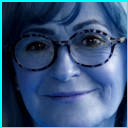

In [43]:

import numpy as np

data = test_recognized_faces['smiling-face'][7]
# data[0:256, 0:256] = [255, 0, 0] # red patch in upper left
img = Image.fromarray(data)
print(type(img))
img.show()

In [19]:
train_dataframe = pd.DataFrame
train_dataframe.columns = [['photo', 'type']]

In [20]:
train_dataframe

pandas.core.frame.DataFrame

In [ ]:
# >>> df = pd.DataFrame(columns=['A'])
# >>> for i in range(5):
# ...     df = df.append({'A': i}, ignore_index=True)
# >>> df

In [23]:
for key in train_recognized_faces:
  for i in range(0, len(train_recognized_faces[key])):
    print(train_recognized_faces[key][0])
    img = Image.fromarray(train_recognized_faces[key][0])
    print(type(img))
    # train_dataframe.append(key)
    # print(len(train_recognized_faces[key]))

[[[  0 255 255]
  [  0 255 255]
  [  0 255 255]
  ...
  [  0 255 255]
  [  0 255 255]
  [  0 255 255]]

 [[  0 255 255]
  [  0 255 255]
  [  0 255 255]
  ...
  [  0 255 255]
  [  0 255 255]
  [  0 255 255]]

 [[  0 255 255]
  [  0 255 255]
  [ 60  71  85]
  ...
  [248 248 248]
  [248 248 248]
  [  0 255 255]]

 ...

 [[  0 255 255]
  [  0 255 255]
  [249 249 249]
  ...
  [249 249 249]
  [249 249 249]
  [  0 255 255]]

 [[  0 255 255]
  [  0 255 255]
  [249 249 249]
  ...
  [249 249 249]
  [249 249 249]
  [  0 255 255]]

 [[  0 255 255]
  [  0 255 255]
  [  0 255 255]
  ...
  [  0 255 255]
  [  0 255 255]
  [  0 255 255]]]


NameError: ignored

# **4.Model**

In [25]:
img_height = 64
img_width = 64
batch_size = 100

In [28]:
#train and validation split
train_dataset = tf.data.Dataset.from_tensor_slices((train_recognized_faces.values(), train_recognized_faces.keys()))

# val_ds = keras.utils.image_dataset_from_directory(
#     train_path,
#     validation_split = 0.3,
#     seed=0,
#     subset='validation',
#     image_size = (img_height, img_width),
#     batch_size = batch_size,
#     label_mode = 'categorical')

ValueError: ignored

In [ ]:
train_ds

NameError: ignored

In [ ]:
model = Sequential()
model.add(layers.Rescaling(1./255))

model.add(layers.Conv2D(64, (5,5), padding='same', activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.RandomRotation(factor = (-1, 1), fill_mode='reflect', interpolation='bilinear',))

model.add(layers.Conv2D(32, (5,5), padding='same', activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Rescaling(scale=2, offset=0.0))

model.add(layers.MaxPool2D((2,2)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))